In [54]:
genecounts = read.csv('counts.csv',row.names = 1)

In [56]:
head(genecounts)

,B14.5,B15.5,B17.5,B20,B34,C14.5,C15.5,C17.5,C20,C34
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000077223,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,46,60,188,448,4377,54,88,85,188,2934
ENSMUSG00000080626,0,0,0,0,3,0,0,0,0,1
ENSMUSG00000006456,740,826,651,474,298,468,673,508,520,310
ENSMUSG00000095913,15,10,8,12,5,16,7,9,5,8


Анализ экспрессии генов

In [114]:
genecounts = as.matrix(genecounts)
mat = data.frame(tissue = substr(colnames(genecounts),1,1), age = substr(colnames(genecounts),2,10))
mat$col = ifelse(mat$tissue == 'B', 'yellow', 'lightblue') #yellow - bark, lightblue - cerebellum
rownames(mat) = colnames(genecounts)

In [115]:
mat

,tissue,age,col
,<chr>,<chr>,<chr>
B14.5,B,14.5,yellow
B15.5,B,15.5,yellow
B17.5,B,17.5,yellow
B20,B,20,yellow
B34,B,34,yellow
C14.5,C,14.5,lightblue
C15.5,C,15.5,lightblue
C17.5,C,17.5,lightblue
C20,C,20,lightblue


In [60]:
table(apply(genecounts,1,sum)>9)


FALSE  TRUE 
  639   813 

In [61]:
genecounts = genecounts[apply(genecounts,1,sum)>9,]

In [62]:
head(genecounts)

,B14.5,B15.5,B17.5,B20,B34,C14.5,C15.5,C17.5,C20,C34
ENSMUSG00000033863,46,60,188,448,4377,54,88,85,188,2934
ENSMUSG00000006456,740,826,651,474,298,468,673,508,520,310
ENSMUSG00000095913,15,10,8,12,5,16,7,9,5,8
ENSMUSG00000025075,1,4,8,1,0,1,0,5,4,0
ENSMUSG00000034108,195,167,180,162,144,191,191,226,176,203
ENSMUSG00000067872,9,10,16,27,43,12,12,19,30,4


In [63]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
 
BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'IRkernel', 'bslib', 'callr', 'data.table', 'devtools', 'digest',
  'jsonlite', 'openssl', 'pkgload', 'processx', 'ps', 'roxygen2', 'sys',
  'tibble', 'tidyverse', 'vctrs', 'xfun', 'yaml', 'zip', 'foreign', 'mgcv',
  'rpart'



In [64]:
library(edgeR) 

In [65]:
edger = DGEList(genecounts) #getting DGEList object
edger = calcNormFactors(edger,method='RLE') #RLE normalisation
edger$samples 

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
B14.5,1,434328,1.0167602
B15.5,1,416550,1.0465000
B17.5,1,414781,1.0478373
B20,1,432334,1.0203292
B34,1,451334,0.8829257
C14.5,1,427733,1.0132987
C15.5,1,413124,1.0487980
C17.5,1,445315,0.9804162
C20,1,446036,1.0527524


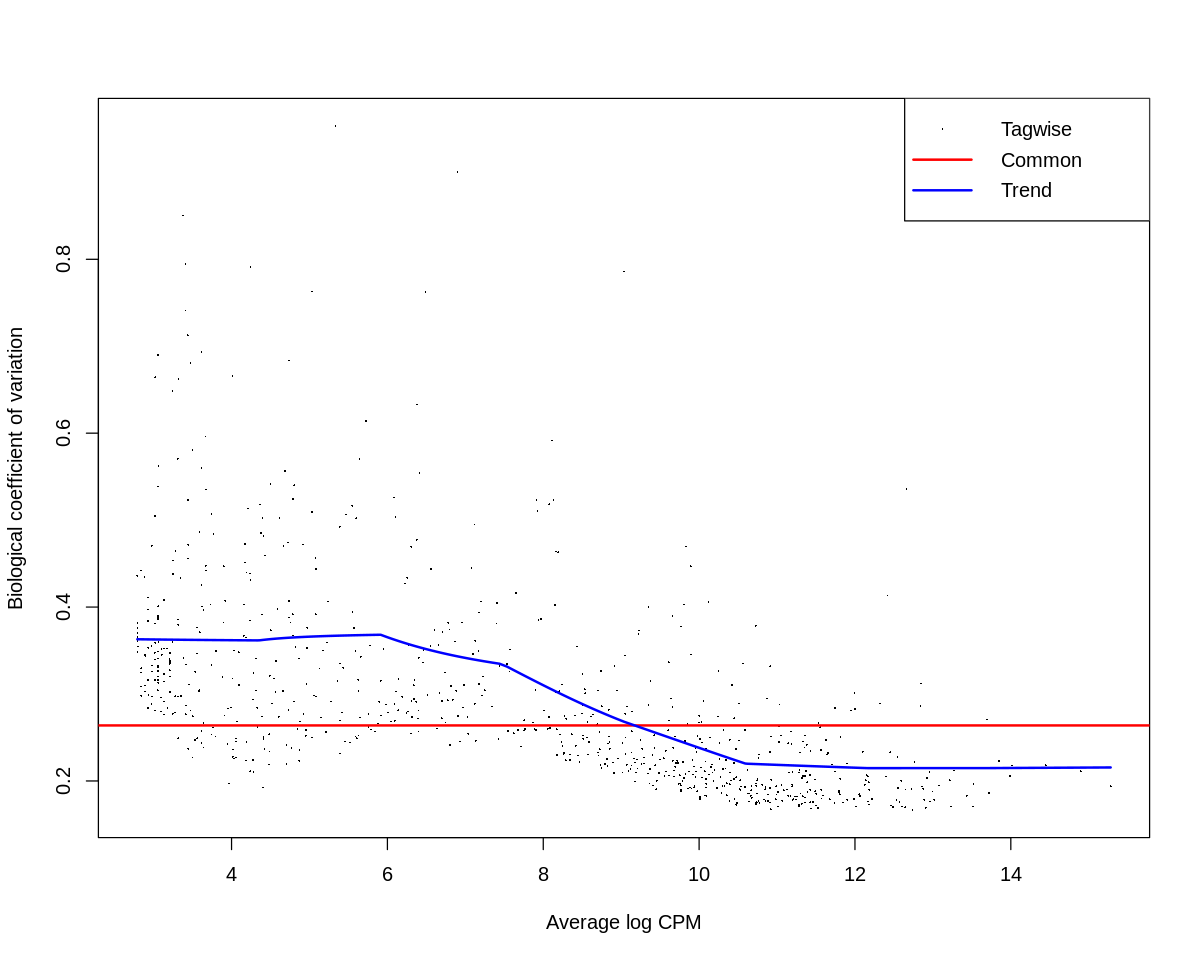

In [116]:
design = model.matrix(~ tissue + age, data = mat)
edger = estimateDisp(edger, design) #estimating the dispersion
plotBCV(edger)

In [68]:
glm = glmFit(edger, design) #fitting GLM

In [69]:
#test for significant differential expression
pv = cbind(tissue   = glmLRT(glm,2)$table$PValue, 
           age   = glmLRT(glm,3)$table$PValue)
rownames(pv) = rownames(genecounts)

In [70]:
head(pv)

,tissue,age
ENSMUSG00000033863,0.0821364,0.1895033
ENSMUSG00000006456,0.1873338,0.2397583
ENSMUSG00000095913,0.6646150,0.1438861
ENSMUSG00000025075,0.5279176,0.4919233
ENSMUSG00000034108,0.3183905,0.7476423
ENSMUSG00000067872,0.5185903,0.9369893


In [71]:
qv = apply(pv,2,p.adjust,m='BH') #batch effect adjustment
apply(qv < 0.05,2,sum) #number of genes significant for 'tissue', 'age'

tissue    age 
    64      3

In [72]:
cpm = cpm(edger) #calculating cpm

In [73]:
qv[order(qv[,2])[1:10],] #10 most significant genes for tissue factor

,tissue,age
ENSMUSG00000053279,5.569253e-23,0.003708092
ENSMUSG00000045664,1.126890e-05,0.006026166
ENSMUSG00000003555,9.305684e-01,0.027094117
ENSMUSG00000063796,9.506821e-01,0.334748722
ENSMUSG00000064941,3.908828e-01,0.334748722
ENSMUSG00000025189,1.730187e-01,0.453640476
ENSMUSG00000036961,1.171270e-02,0.453640476
ENSMUSG00002075054,9.831346e-01,0.453640476
ENSMUSG00000061451,2.927777e-01,0.460832333
ENSMUSG00000068466,3.480796e-01,0.495837291


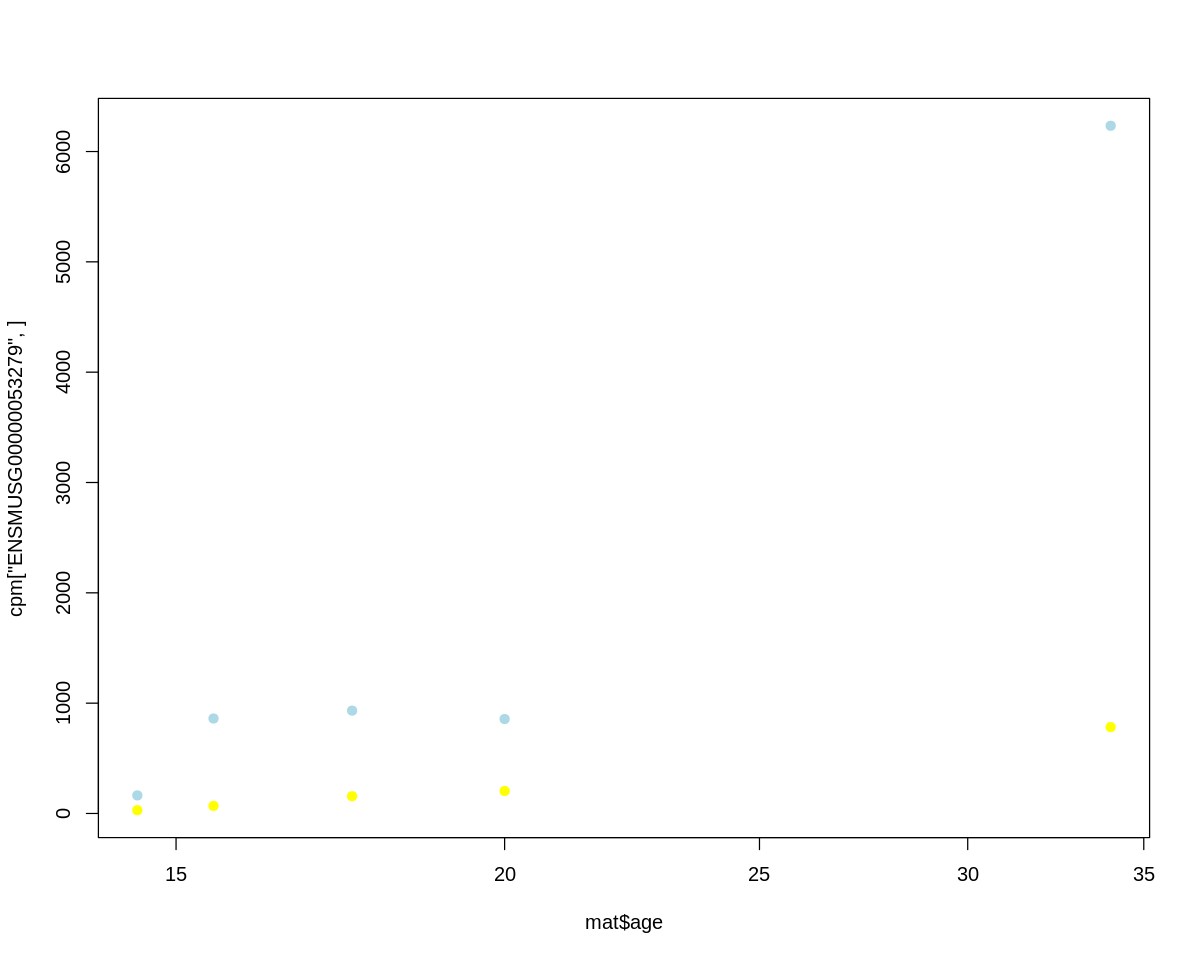

In [117]:
plot(mat$age,cpm['ENSMUSG00000053279',],pch=19,col=mat$col,log='x') 
#expression level grows for cerebellum - however, we can see it only for one sample; not representative

Кластеризация генов

In [78]:
install.packages('dendextend', dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



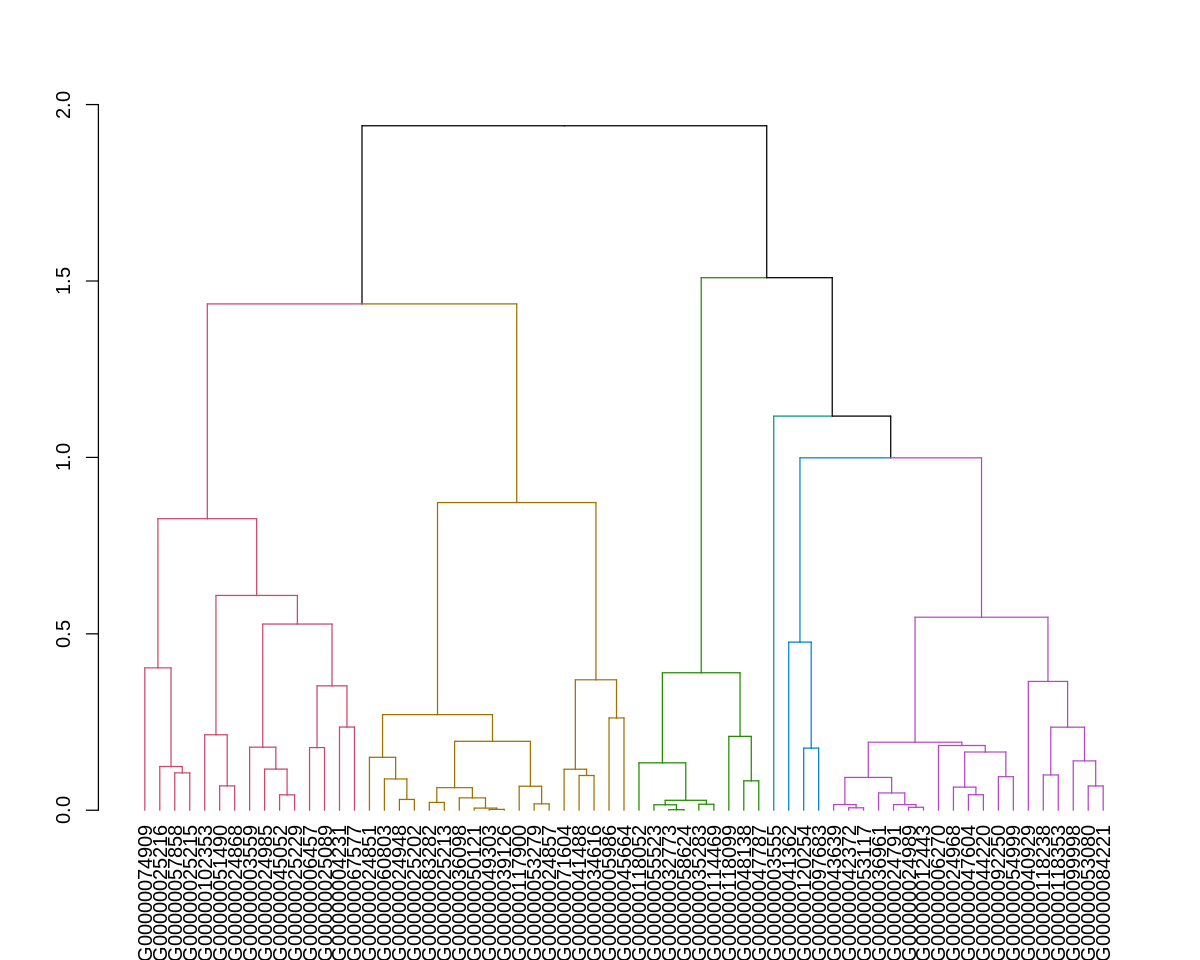

In [105]:
cpm.s = cpm[apply(qv,1,min)<0.05,] #take significant genes by cpm
hcluster = hclust(as.dist(1-cor(t(cpm.s)))) #hierarchical clusterisation
suppressPackageStartupMessages(library(dendextend))
dend = as.dendrogram(hcluster)
dend_col = color_branches(dend, k = 6) #colored division into 6 cluster
options(repr.plot.width=10, repr.plot.height=8)
plot(dend_col)

Нормализация экспрессии генов. Построение графиков зависимости среднего z-score от возраста

In [106]:
cpm.s = t(scale(t(cpm.s))) #z-score normalisation

In [110]:
cl_6 = cutree(hcluster,6) #division into 6 clusters
table(cl_6)

cl_6
 1  2  3  4  5  6 
18 15 19  9  3  1 

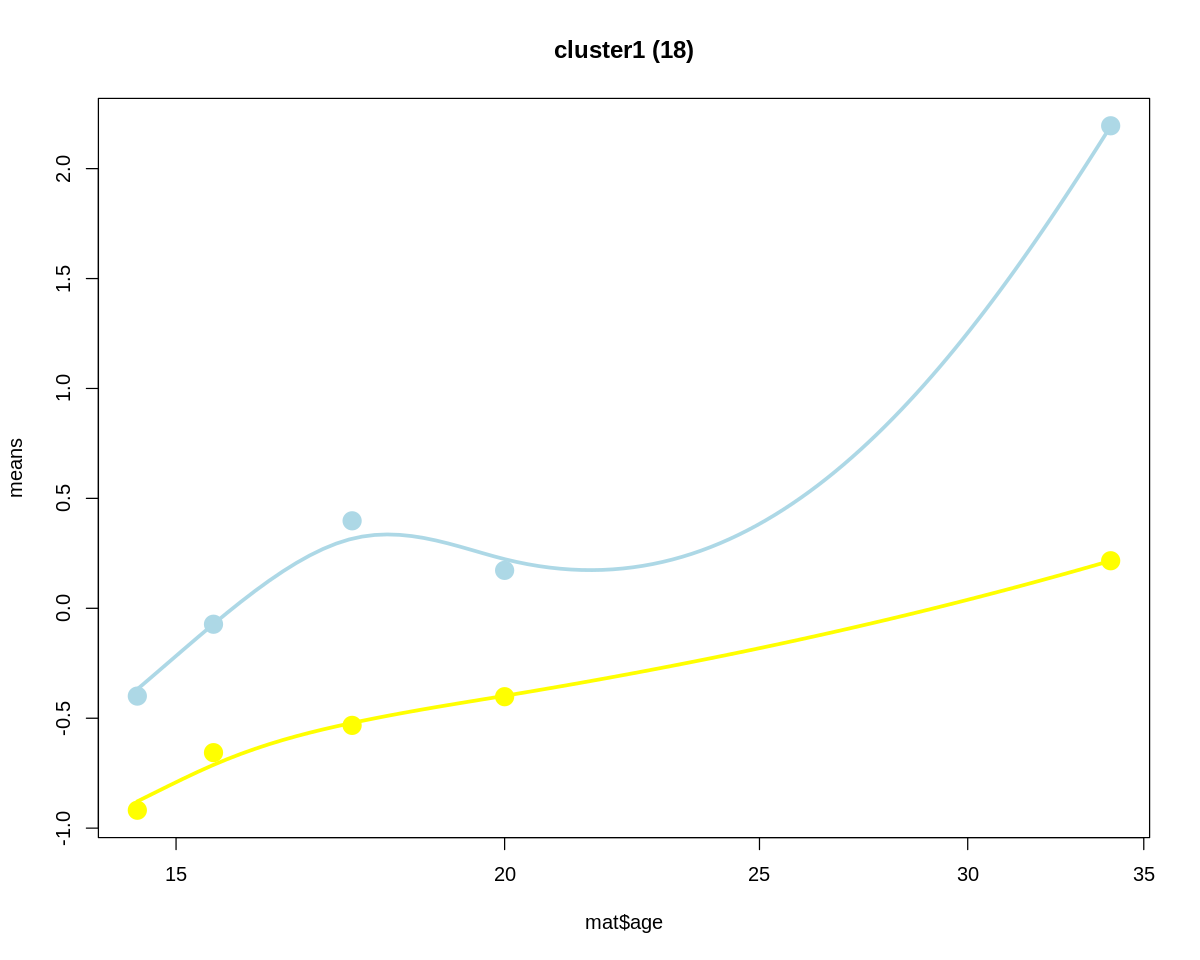

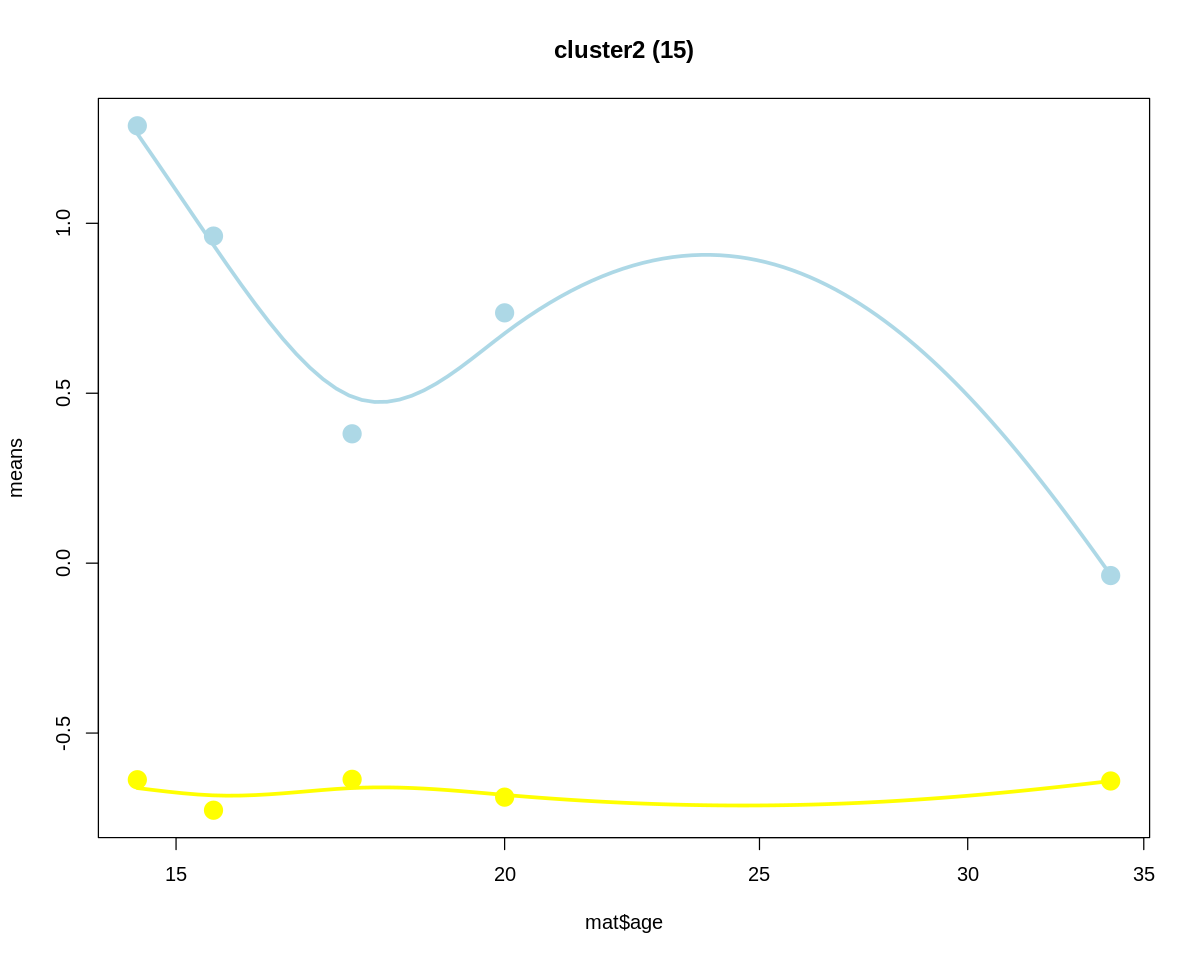

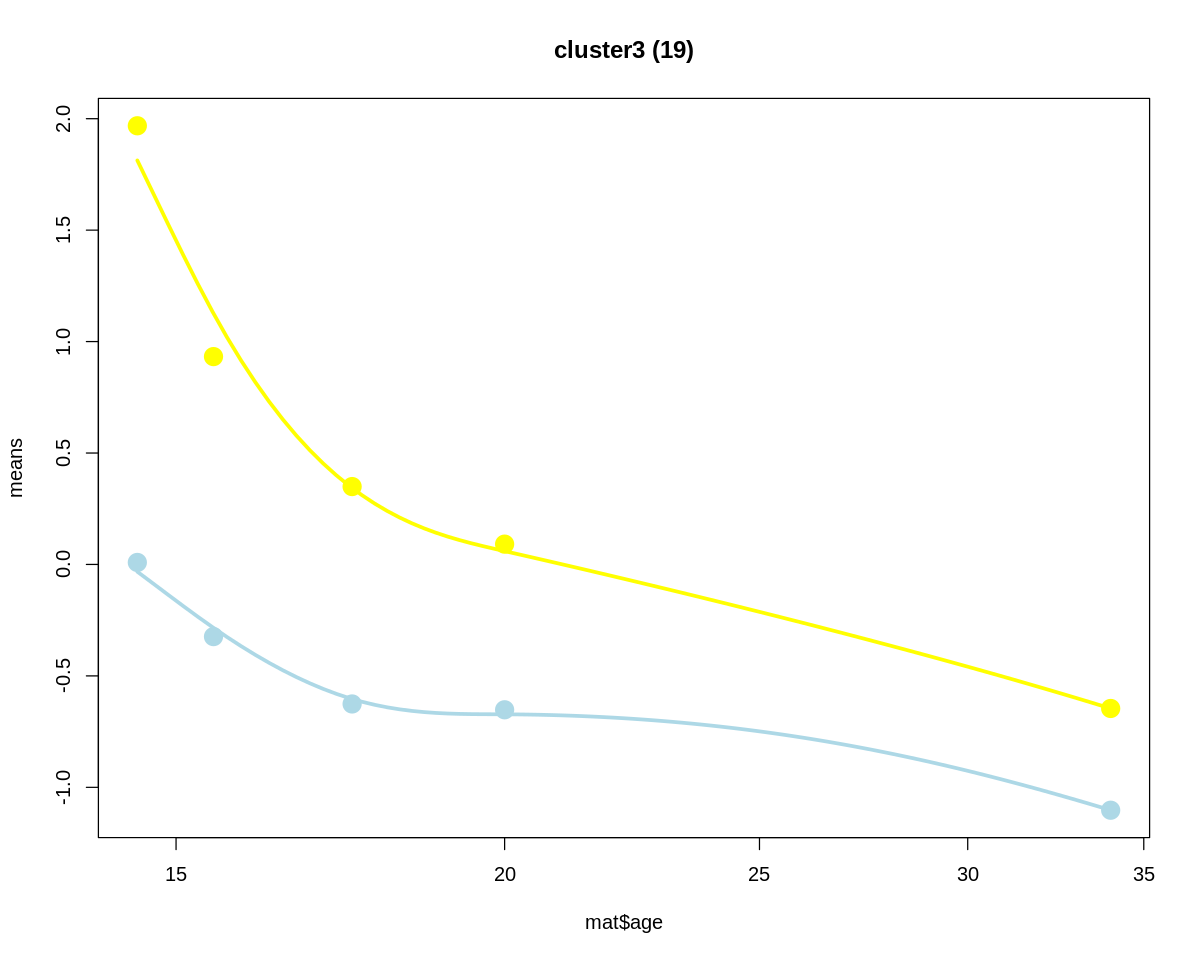

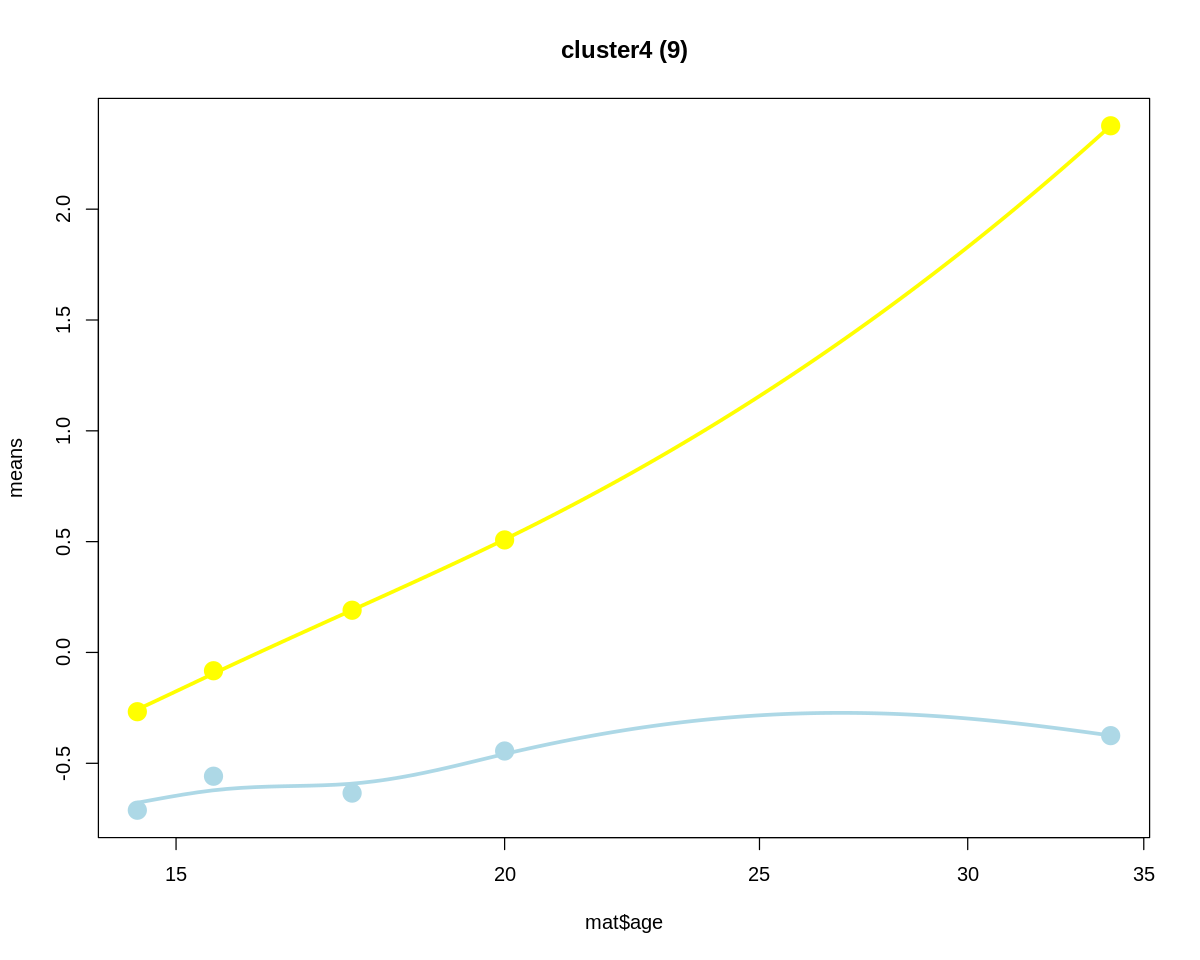

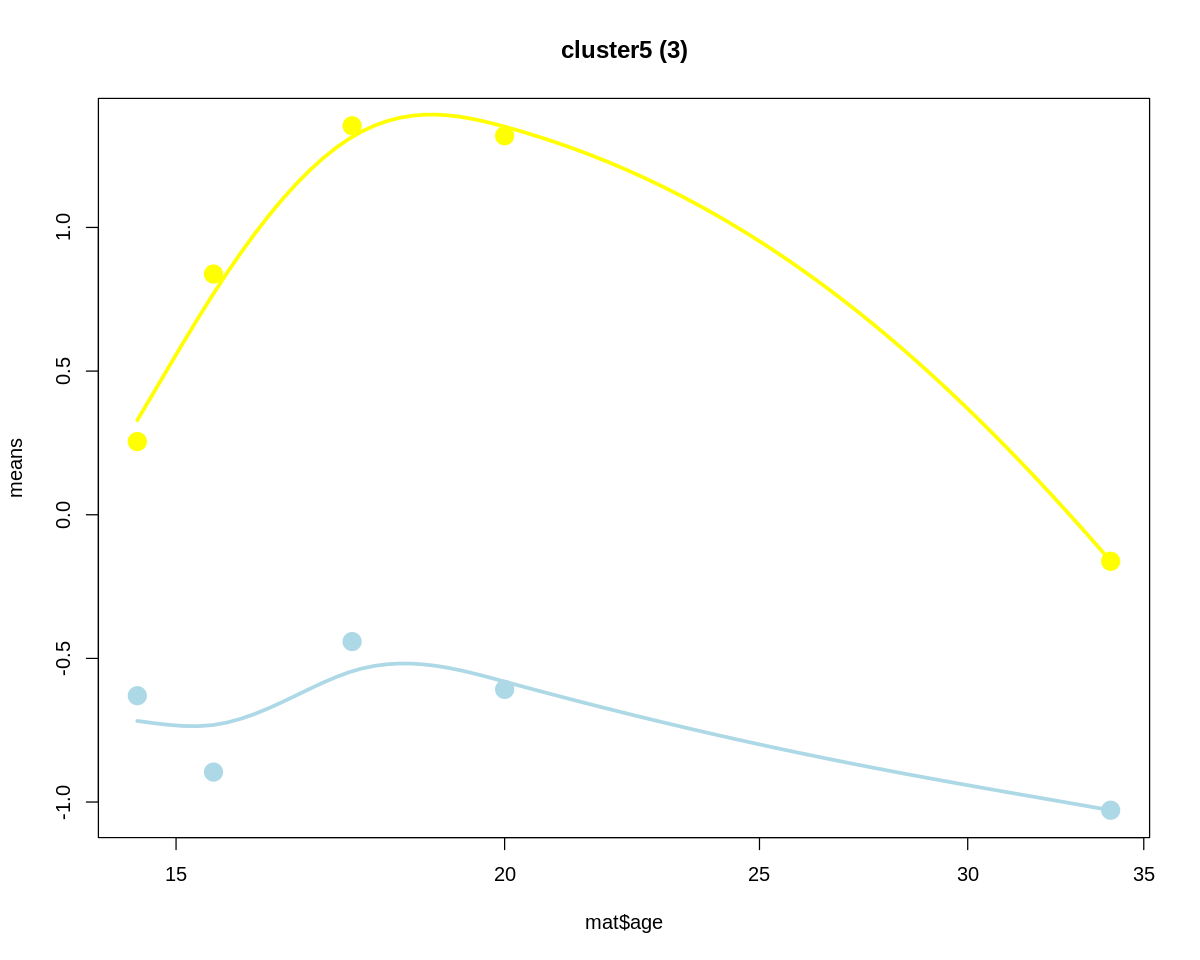

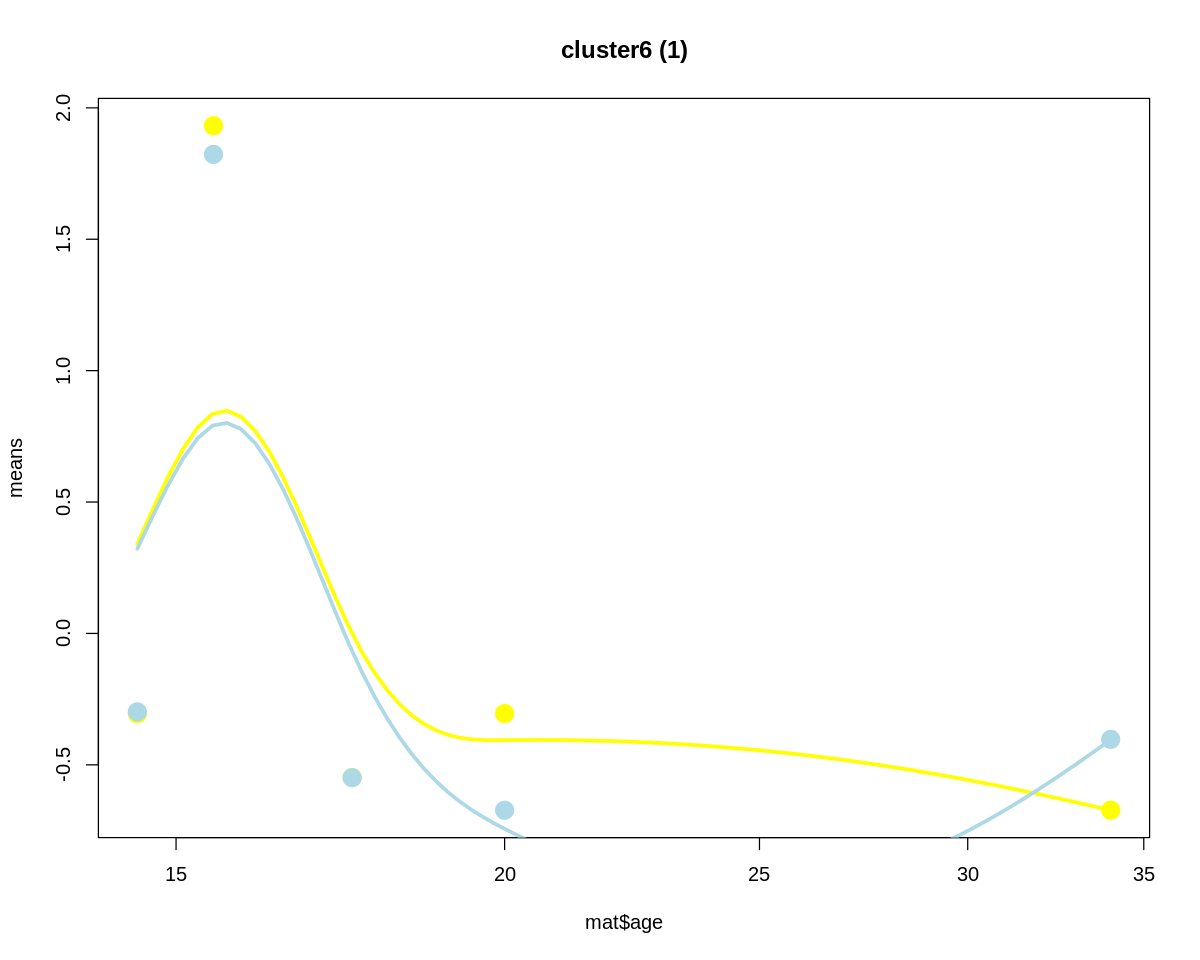

In [118]:
for(cluster in unique(cl_6)){  
  means = apply(cpm.s[cl_6==cluster,,drop=F],2,mean)  #mean expression level in cluster
  plot(mat$age,means,pch=19,col=mat$col,main=paste0(sprintf("cluster%s", cluster),' (',sum(cl_6==cluster),')'),log='x',cex=2)

  for(tis in unique(mat$tissue)){  #for each tissue 
    f = mat$tissue == tis #samples from given tissue
    ss = smooth.spline(mat$age[f],means[f],df=4)
    ss = predict(ss,seq(min(mat$age),max(mat$age),length.out=100))
    lines(ss,lwd=3,col=mat$col[f][1]) #approximation plotting
  }
}